In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Grabbing a bunch of tech stocks for our portfolio
# symbol = 'WIKI/TSLA'
# tsla_df = web.DataReader(symbol, 'quandl', '2017-06-01', '2021-06-01',0,api_key='VyMgAh2xwHRz5fEhZH4-')
# symbol = 'WIKI/QCOM'
# qcom_df = web.DataReader(symbol, 'quandl', '2017-06-01', '2021-06-01',0,api_key='VyMgAh2xwHRz5fEhZH4-')
# symbol = 'WIKI/NKE'
# nke_df = web.DataReader(symbol, 'quandl', '2017-06-01', '2021-06-01',0,api_key='VyMgAh2xwHRz5fEhZH4-')
# symbol = 'WIKI/DIS'
# dis_df = web.DataReader(symbol, 'quandl', '2017-06-01', '2021-06-01',0,api_key='VyMgAh2xwHRz5fEhZH4-')
# symbol = 'WIKI/JNJ'
# jnj_df = web.DataReader(symbol, 'quandl', '2017-06-01', '2021-06-01',0,api_key='VyMgAh2xwHRz5fEhZH4-')

In [ ]:
# Grabbing a bunch of tech stocks for our portfolio
# aapl = quandl.get('WIKI/TSLA',start_date=start,end_date=end)
# import quandl


# start = pd.to_datetime('2017-06-01')
# end = pd.to_datetime('2021-06-01')

In [2]:
# Download and get Daily Returns
tsla = pd.read_csv('./data/WIKI-TSLA.csv',index_col='Date',parse_dates=True)
qcom = pd.read_csv('./data/WIKI-QCOM.csv',index_col='Date',parse_dates=True)
nke = pd.read_csv('./data/WIKI-NKE.csv',index_col='Date',parse_dates=True)
dis = pd.read_csv('./data/WIKI-DIS.csv',index_col='Date',parse_dates=True)
jnj = pd.read_csv('./data/WIKI-JNJ.csv',index_col='Date',parse_dates=True)

In [3]:
stocks = pd.concat([tsla['Adj. Close'],qcom['Adj. Close'],nke['Adj. Close'],dis['Adj. Close'],jnj['Adj. Close']],axis=1)
stocks.columns = ['tsla','qcom','nke','dis', 'jnj']

Created dataframe with the closeing prices

In [4]:
stocks.head()

,tsla,qcom,nke,dis,jnj
Date,,,,,
1962-01-02,NaN,NaN,NaN,0.141259,NaN
1962-01-03,NaN,NaN,NaN,0.143155,NaN
1962-01-04,NaN,NaN,NaN,0.143155,NaN
1962-01-05,NaN,NaN,NaN,0.143648,NaN
1962-01-08,NaN,NaN,NaN,0.143155,NaN


In [5]:
stocks.pct_change(1).mean()

tsla    0.001766
qcom    0.001235
nke     0.001002
dis     0.000707
jnj     0.000570
dtype: float64

In [6]:
stocks.pct_change(1).corr()

,tsla,qcom,nke,dis,jnj
tsla,1.000000,0.227461,0.237808,0.266527,0.191565
qcom,0.227461,1.000000,0.227505,0.279320,0.177891
nke,0.237808,0.227505,1.000000,0.277021,0.231250
dis,0.266527,0.279320,0.277021,1.000000,0.320459
jnj,0.191565,0.177891,0.231250,0.320459,1.000000


In [7]:
stocks.pct_change(1).head()

,tsla,qcom,nke,dis,jnj
Date,,,,,
1962-01-02,NaN,NaN,NaN,NaN,NaN
1962-01-03,NaN,NaN,NaN,0.013423,NaN
1962-01-04,NaN,NaN,NaN,0.000000,NaN
1962-01-05,NaN,NaN,NaN,0.003444,NaN
1962-01-08,NaN,NaN,NaN,-0.003432,NaN


In [8]:
log_ret = np.log(stocks/stocks.shift(1))
log_ret.head()

,tsla,qcom,nke,dis,jnj
Date,,,,,
1962-01-02,NaN,NaN,NaN,NaN,NaN
1962-01-03,NaN,NaN,NaN,0.013334,NaN
1962-01-04,NaN,NaN,NaN,0.000000,NaN
1962-01-05,NaN,NaN,NaN,0.003438,NaN
1962-01-08,NaN,NaN,NaN,-0.003438,NaN


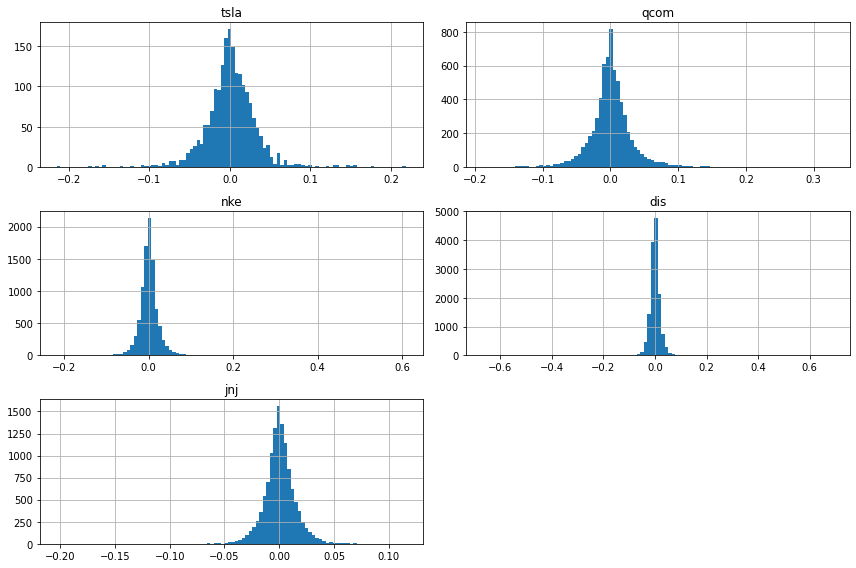

In [9]:
log_ret.hist(bins=100,figsize=(12,8))
plt.tight_layout()

In [10]:
log_ret.mean()

tsla    0.001262
qcom    0.000734
nke     0.000735
dis     0.000464
jnj     0.000464
dtype: float64

In [11]:
log_ret.cov() * 252

,tsla,qcom,nke,dis,jnj
tsla,0.252794,0.030143,0.028162,0.027906,0.013888
qcom,0.030143,0.251253,0.036720,0.042058,0.019030
nke,0.028162,0.036720,0.128582,0.031298,0.019875
dis,0.027906,0.042058,0.031298,0.123429,0.026420
jnj,0.013888,0.019030,0.019875,0.026420,0.053511


In [18]:
np.random.seed(101)

num_ports = 5000

all_weights = np.zeros((num_ports, len(stocks.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for ind in range(num_ports):

#    print(stocks.columns)

    # Weights
    weights = np.array(np.random.random(5))
    weights = weights/np.sum(weights)
    
    # Save Weights
    all_weights[ind,:] = weights
    
#    print("Expected Portfolio Return")
    ret_arr[ind] = np.sum( (log_ret.mean() * weights) * 252)

#    print("Expected Volatility")
    vol_arr[ind] = np.sqrt(np.dot(weights.T,np.dot(log_ret.cov()*252, weights)))

#    print("Sharpe Ratio")
    sharpe_arr[ind] = ret_arr[ind]/vol_arr[ind]

In [19]:
sharpe_arr.max()

0.8529096410192284

In [20]:
sharpe_arr.argmax()

72

In [21]:
all_weights[1420,:]

array([0.13048674, 0.24716991, 0.0237618 , 0.27615635, 0.3224252 ])

In [22]:
max_sr_ret = ret_arr[1420]
max_sr_vol = vol_arr[1420]

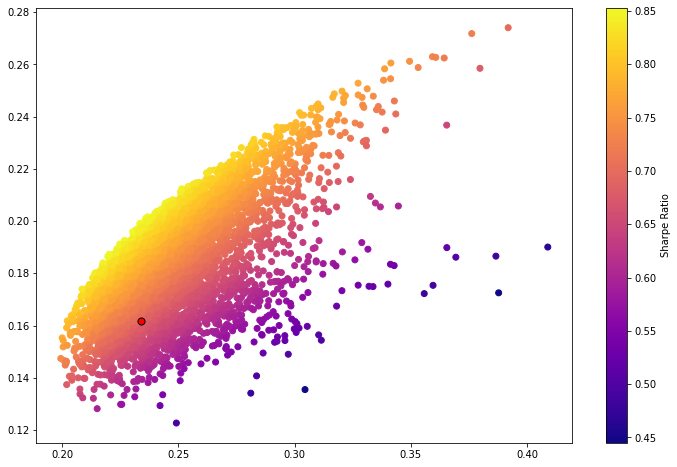

In [23]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr,ret_arr,c=sharpe_arr,cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel = 'Volatility'
plt.ylabel = 'Return'

plt.scatter(max_sr_vol,max_sr_ret,c='red',s=50,edgecolors='black')

In [24]:
def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = np.sum(log_ret.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov()*252,weights)))
    sr=ret/vol
    return np.array([ret,vol,sr])

In [ ]:
from scipy.optimize import minimize

In [ ]:
def neg_sharpe(weights):
    return get_ret_vol_sr(weights)[2] * -1

In [ ]:
def check_sum(weights):
    #return 0 if the sum of the weights is 1
    return np.sum(weights) - 1

In [ ]:
cons = ({'type':'eq','fun':check_sum})

In [ ]:
bounds = ((0,1),(0,1),(0,1),(0,1))

In [ ]:
init_guess = [0.25,0.25,0.25,0.25]

In [ ]:
opt_results = minimize(neg_sharpe,init_guess,method='SLSQP',bounds=bounds,constraints=cons)

In [ ]:
opt_results

In [ ]:
opt_results.x

In [ ]:
get_ret_vol_sr(opt_results.x)

In [ ]:
frontier_y = np.linspace(0,0.3,100)

In [ ]:
def minimize_volatility(weights):
    return get_ret_vol_sr(weights)[1]

In [ ]:
frontier_volatility = []

for possible_return in frontier_y:
    cons = ({'type':'eq', 'fun':check_sum},
           {'type':'eq','fun':lambda w: get_ret_vol_sr(w)[0]-possible_return})
    
    results = minimize(minimize_volatility,init_guess,method='SLSQP',bounds=bounds,constraints=cons)
    
    frontier_volatility.append(results['fun'])

In [ ]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr,ret_arr,c=sharpe_arr,cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel = 'Volatility'
plt.ylabel = 'Return'

plt.plot(frontier_volatility, frontier_y, 'g--',linewidth=3)